In [1]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# Dataset paths
base_path = "wound-classification-using-images-and-locations-main/wound-classification-using-images-and-locations-main/dataset"
train_csv = os.path.join(base_path, "Train/wound_locations_Labels_AZH_Train.csv")
test_csv = os.path.join(base_path, "Test/wound_locations_Labels_AZH_Test.csv")
train_img_dir = os.path.join(base_path, "Train")
test_img_dir = os.path.join(base_path, "Test")

# Read CSV files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Clean data
train_df["index"] = train_df["index"].str.replace(r"\\", "/", regex=True)
test_df["index"] = test_df["index"].str.replace(r"\\", "/", regex=True)

# Drop NaNs and filter labels
valid_labels = [0, 1, 2, 3, 4, 5]
train_df.dropna(subset=["Labels"], inplace=True)
test_df.dropna(subset=["Labels"], inplace=True)
train_df = train_df[train_df["Labels"].isin(valid_labels)]
test_df = test_df[test_df["Labels"].isin(valid_labels)]


In [ ]:
# Training function with improved error handling and checkpointing
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    # Initialize best model tracking
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Create checkpoint directory if it doesn't exist
    checkpoint_dir = 'checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Training phase
            model.train()
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            # Progress bar for training
            train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
            
            for inputs, labels in train_pbar:
                try:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass and optimize
                        loss.backward()
                        optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Update progress bar
                    train_pbar.set_postfix({
                        'loss': loss.item(),
                        'acc': (torch.sum(preds == labels.data).item() / inputs.size(0))
                    })
                    
                except RuntimeError as e:
                    print(f"Error during training batch: {e}")
                    continue
            
            # Calculate epoch training statistics
            epoch_train_loss = running_loss / total_samples
            epoch_train_acc = running_corrects.double() / total_samples
            
            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)
            
            # Validation phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            # Progress bar for validation
            val_pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}')
            
            with torch.no_grad():
                for inputs, labels in val_pbar:
                    try:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        
                        # Forward pass
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Statistics
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        total_samples += inputs.size(0)
                        
                        # Update progress bar
                        val_pbar.set_postfix({
                            'loss': loss.item(),
                            'acc': (torch.sum(preds == labels.data).item() / inputs.size(0))
                        })
                        
                    except RuntimeError as e:
                        print(f"Error during validation batch: {e}")
                        continue
            
            # Calculate epoch validation statistics
            epoch_val_loss = running_loss / total_samples
            epoch_val_acc = running_corrects.double() / total_samples
            
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)
            
            # Print epoch statistics
            print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
            print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
            
            # Save checkpoint for each epoch
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
                'train_acc': epoch_train_acc,
                'val_acc': epoch_val_acc,
            }
            torch.save(checkpoint, f'{checkpoint_dir}/epoch_{epoch+1}.pth')
            
            # Deep copy the model if best accuracy
            if epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save best model
                torch.save({
                    'model_state_dict': best_model_wts,
                    'val_acc': best_acc,
                }, 'wound_classifier_best.pth')
            
            # Step the scheduler
            if scheduler:
                scheduler.step()
                
            print()
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Saving current state...")
        # Save the current state
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
            'train_acc': epoch_train_acc,
            'val_acc': epoch_val_acc,
        }
        torch.save(checkpoint, f'{checkpoint_dir}/interrupted_checkpoint.pth')
        print("Checkpoint saved. You can resume training from this point.")
    
    except Exception as e:
        print(f"An error occurred during training: {e}")
        # Save the current state
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        }
        torch.save(checkpoint, f'{checkpoint_dir}/error_checkpoint.pth')
        print("Emergency checkpoint saved.")
        raise e
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses,
                  'train_accs': train_accs, 'val_accs': val_accs}


In [ ]:
# Function to resume training from checkpoint
def resume_training(checkpoint_path, model, optimizer, scheduler=None):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch']
    
    print(f"Resuming from epoch {start_epoch}")
    print(f"Previous training metrics:")
    print(f"Train Loss: {checkpoint['train_loss']:.4f} Acc: {checkpoint['train_acc']:.4f}")
    print(f"Val Loss: {checkpoint['val_loss']:.4f} Acc: {checkpoint['val_acc']:.4f}")
    
    return model, optimizer, scheduler, start_epoch

# Example usage:
# If training was interrupted, you can resume from the last checkpoint:
"""
checkpoint_path = 'checkpoints/interrupted_checkpoint.pth'
model, optimizer, scheduler, start_epoch = resume_training(checkpoint_path, model, optimizer, scheduler)
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                           num_epochs=25-start_epoch, device=device)  # Adjust remaining epochs
"""


C:\Users\HP\AppData\Local\Temp\ipykernel_22160\136516694.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="label_name", order=train_df["label_name"].value_counts().index, palette="viridis")


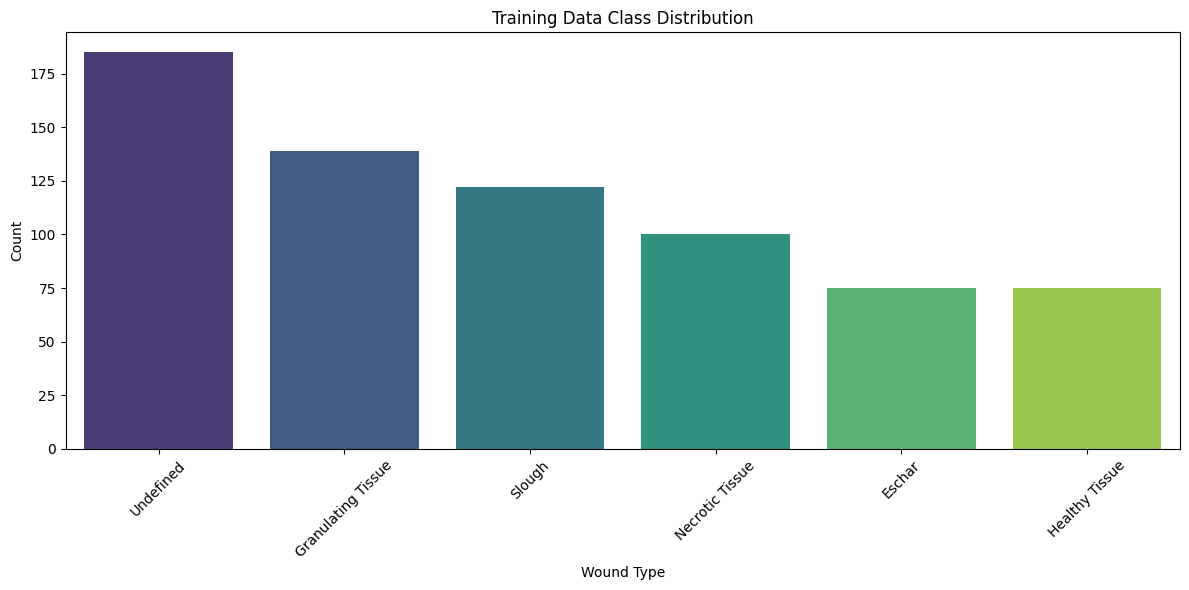


Class weights for balanced training:
Eschar: 1.55
Granulating Tissue: 0.83
Healthy Tissue: 1.55
Necrotic Tissue: 1.16
Slough: 0.95
Undefined: 0.63


In [3]:
# Create label mapping
label_map = {
    0: "Eschar", 1: "Granulating Tissue", 2: "Healthy Tissue",
    3: "Necrotic Tissue", 4: "Slough", 5: "Undefined"
}
train_df["label_name"] = train_df["Labels"].map(label_map)

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x="label_name", order=train_df["label_name"].value_counts().index, palette="viridis")
plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.xlabel("Wound Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["Labels"]),
    y=train_df["Labels"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("\nClass weights for balanced training:")
for label, weight in enumerate(class_weights):
    print(f"{label_map[label]}: {weight:.2f}")


In [4]:
class WoundDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_train=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'index']
        label = int(self.df.loc[idx, 'Labels'])
        img_path = os.path.join(self.image_dir, f"{img_name}.jpg")
        
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224))
            label = 5  # Undefined fallback
            
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Enhanced data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data and create dataloaders
train_df_sampled, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df["Labels"], random_state=42
)

# Create datasets
train_dataset = WoundDataset(train_df_sampled, train_img_dir, train_transform, is_train=True)
val_dataset = WoundDataset(val_df, train_img_dir, val_transform, is_train=False)
test_dataset = WoundDataset(test_df, test_img_dir, val_transform, is_train=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
def visualize_predictions_by_class(model, test_loader, samples_per_class=3):
    model.eval()
    # Dictionary to store examples for each class
    class_examples = {label: {'images': [], 'preds': []} for label in range(6)}  # 6 classes
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            batch_images = inputs.cpu()
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Store examples for each class
            for img, target, pred in zip(batch_images, targets, predicted.cpu()):
                target_class = target.item()
                if len(class_examples[target_class]['images']) < samples_per_class:
                    class_examples[target_class]['images'].append(img)
                    class_examples[target_class]['preds'].append(pred.item())
            
            # Check if we have enough examples for each class
            if all(len(examples['images']) >= samples_per_class for examples in class_examples.values()):
                break
    
    # Create a figure with subplots for each class
    plt.figure(figsize=(20, 12))
    class_names = ['Background (BG)', 'Dehiscence (D)', 'Necrosis (N)', 
                  'Pressure Injury (P)', 'Surgical Site Infection (S)', 'Various (V)']
    
    for class_idx, class_name in enumerate(class_names):
        examples = class_examples[class_idx]
        for i, (img, pred) in enumerate(zip(examples['images'], examples['preds'])):
            plt.subplot(6, samples_per_class, class_idx * samples_per_class + i + 1)
            
            # Denormalize image
            img = img.numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            correct = class_idx == pred
            color = 'green' if correct else 'red'
            plt.title(f'True: {class_names[class_idx]}\nPred: {class_names[pred]}', 
                     color=color, fontsize=8)
            plt.axis('off')
    
    plt.suptitle('Predictions for Each Wound Class', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualize predictions for all classes
print("\nSample predictions for each class:")
visualize_predictions_by_class(model, test_loader, samples_per_class=3)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

# Define the class names
class_names = ['Background (BG)', 'Dehiscence (D)', 'Necrosis (N)', 
              'Pressure Injury (P)', 'Surgical Site Infection (S)', 'Various (V)']

def load_and_preprocess_image(image_path):
    # Define the same transforms used during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def predict_image(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        return predicted.item(), confidence.item()

def visualize_predictions_by_class(model, data_dir, device, samples_per_class=3):
    # Dictionary to store examples for each class
    class_examples = {i: [] for i in range(len(class_names))}
    
    # Class folders
    class_folders = ['BG', 'D', 'N', 'P', 'S', 'V']
    
    # Collect examples for each class
    for class_idx, folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, 'Test', folder)
        image_files = os.listdir(class_path)[:samples_per_class]
        
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image_tensor = load_and_preprocess_image(image_path)
            pred_class, confidence = predict_image(model, image_tensor, device)
            
            # Store original image, prediction, and confidence
            original_image = Image.open(image_path).convert('RGB')
            class_examples[class_idx].append({
                'image': original_image,
                'pred': pred_class,
                'conf': confidence
            })
    
    # Create visualization
    plt.figure(figsize=(20, 4*len(class_names)))
    
    for class_idx in range(len(class_names)):
        examples = class_examples[class_idx]
        
        for i, example in enumerate(examples):
            plt.subplot(len(class_names), samples_per_class, class_idx * samples_per_class + i + 1)
            
            # Display image
            plt.imshow(example['image'])
            
            # Color code based on correct/incorrect prediction
            correct = class_idx == example['pred']
            color = 'green' if correct else 'red'
            
            # Add title with true label, prediction, and confidence
            plt.title(f'True: {class_names[class_idx]}\nPred: {class_names[example["pred"]]}\nConf: {example["conf"]:.2f}', 
                     color=color, fontsize=8)
            plt.axis('off')
    
    plt.suptitle('Predictions for Each Wound Class', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Example usage
data_dir = 'wound-classification-using-images-and-locations-main/wound-classification-using-images-and-locations-main/dataset'
visualize_predictions_by_class(model, data_dir, device, samples_per_class=3)


In [ ]:
def visualize_predictions_all_labels(model, test_loader, samples_per_class=3):
    model.eval()
    # Dictionary to store examples for each class
    class_examples = {label: {'images': [], 'labels': [], 'preds': []} for label in range(6)}
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            batch_images = inputs.cpu()
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Store examples for each class
            for img, label, pred in zip(batch_images, targets, predicted.cpu()):
                label_idx = label.item()
                if len(class_examples[label_idx]['images']) < samples_per_class:
                    class_examples[label_idx]['images'].append(img)
                    class_examples[label_idx]['labels'].append(label_idx)
                    class_examples[label_idx]['preds'].append(pred.item())
            
            # Check if we have enough examples for all classes
            if all(len(examples['images']) >= samples_per_class for examples in class_examples.values()):
                break
    
    # Plotting
    num_classes = 6
    plt.figure(figsize=(15, 12))  # Increased height to accommodate all classes
    
    for class_idx in range(num_classes):
        images = class_examples[class_idx]['images']
        labels = class_examples[class_idx]['labels']
        preds = class_examples[class_idx]['preds']
        
        for i in range(len(images)):
            plt.subplot(num_classes, samples_per_class, class_idx * samples_per_class + i + 1)
            
            # Denormalize image
            img = images[i].numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            
            # Color-code the title based on prediction correctness
            correct = labels[i] == preds[i]
            color = 'green' if correct else 'red'
            
            plt.title(f'True: {label_map[labels[i]]}\nPred: {label_map[preds[i]]}', 
                     color=color, fontsize=8)
            plt.axis('off')
    
    plt.suptitle('Sample Predictions for Each Class', fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()

# Visualize predictions for all classes
print("\nSample predictions for each class:")
visualize_predictions_all_labels(model, test_loader, samples_per_class=3)


In [5]:
class ImprovedWoundClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(ImprovedWoundClassifier, self).__init__()
        
        # Use pretrained ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=True)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-8]:
            param.requires_grad = False
            
        # Modify final layers
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

# Initialize model
model = ImprovedWoundClassifier().to(device)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The 

In [8]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset paths
base_path = "wound-classification-using-images-and-locations-main/wound-classification-using-images-and-locations-main/dataset"
train_csv = os.path.join(base_path, "Train/wound_locations_Labels_AZH_Train.csv")
test_csv = os.path.join(base_path, "Test/wound_locations_Labels_AZH_Test.csv")
train_img_dir = os.path.join(base_path, "Train")
test_img_dir = os.path.join(base_path, "Test")

# Read CSV files
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Clean data
train_df["index"] = train_df["index"].str.replace(r"\\", "/", regex=True)
test_df["index"] = test_df["index"].str.replace(r"\\", "/", regex=True)

# Drop NaNs and filter labels
valid_labels = [0, 1, 2, 3, 4, 5]
train_df.dropna(subset=["Labels"], inplace=True)
test_df.dropna(subset=["Labels"], inplace=True)
train_df = train_df[train_df["Labels"].isin(valid_labels)]
test_df = test_df[test_df["Labels"].isin(valid_labels)]

# Create label mapping
label_map = {
    0: "Eschar", 1: "Granulating Tissue", 2: "Healthy Tissue",
    3: "Necrotic Tissue", 4: "Slough", 5: "Undefined"
}
train_df["label_name"] = train_df["Labels"].map(label_map)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["Labels"]),
    y=train_df["Labels"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Dataset class
class WoundDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_train=True):
        """
        Initialize the dataset.
        Args:
            df (pd.DataFrame): DataFrame containing image paths and labels
            image_dir (str): Directory containing the images
            transform: Optional transform to be applied on a sample
            is_train (bool): Whether this is training data
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.is_train = is_train
        
        # Validate data at initialization
        self._validate_data()
        
        # Cache image paths
        self.image_paths = []
        self.valid_indices = []
        
        for idx in range(len(self.df)):
            img_name = self.df.loc[idx, 'index']
            img_path = os.path.join(self.image_dir, f"{img_name}.jpg")
            
            if os.path.exists(img_path):
                self.image_paths.append(img_path)
                self.valid_indices.append(idx)
            else:
                print(f"Warning: Image not found at {img_path}")
        
        print(f"Dataset initialized with {len(self.valid_indices)} valid images out of {len(self.df)} total entries")
    
    def _validate_data(self):
        """Validate the dataset at initialization."""
        # Check if directory exists
        if not os.path.exists(self.image_dir):
            raise ValueError(f"Image directory not found: {self.image_dir}")
        
        # Check required columns
        required_cols = ['index', 'Labels']
        missing_cols = [col for col in required_cols if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Validate labels
        valid_labels = set(range(6))  # 0 to 5
        invalid_labels = set(self.df['Labels'].unique()) - valid_labels
        if invalid_labels:
            raise ValueError(f"Invalid labels found in dataset: {invalid_labels}")
    
    def __len__(self):
        """Return the number of valid images in the dataset."""
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        Args:
            idx (int): Index
        Returns:
            tuple: (image, label) where image is a transformed PIL Image and label is an integer
        """
        try:
            # Get the actual index from valid indices
            actual_idx = self.valid_indices[idx]
            
            # Get image path and label
            img_path = self.image_paths[idx]
            label = int(self.df.loc[actual_idx, 'Labels'])
            
            try:
                # Load and convert image
                with Image.open(img_path) as img:
                    image = img.convert('RGB')
                
                # Apply transformations
                if self.transform:
                    try:
                        image = self.transform(image)
                    except Exception as e:
                        print(f"Error applying transform to image {img_path}: {str(e)}")
                        # Return a basic transformed image
                        image = self._get_default_image()
                
                return image, label
                
            except Exception as e:
                print(f"Error loading image {img_path}: {str(e)}")
                return self._get_default_image(), 5  # Return default image and Undefined class
                
        except Exception as e:
            print(f"Critical error in __getitem__ for idx {idx}: {str(e)}")
            return self._get_default_image(), 5
    
    def _get_default_image(self):
        """Return a default image tensor when loading fails."""
        if self.transform:
            try:
                # Create a black image and apply the same transforms
                default_img = Image.new('RGB', (224, 224), 'black')
                return self.transform(default_img)
            except:
                # If transform fails, return a zero tensor
                return torch.zeros((3, 224, 224))
        return torch.zeros((3, 224, 224))
    
    def get_image_path(self, idx):
        """Get the image path for a given index (useful for debugging)."""
        if 0 <= idx < len(self.valid_indices):
            return self.image_paths[idx]
        return None

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data and create dataloaders
train_df_sampled, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df["Labels"], random_state=42
)

# Create datasets with error handling
try:
    train_dataset = WoundDataset(train_df_sampled, train_img_dir, train_transform, is_train=True)
    val_dataset = WoundDataset(val_df, train_img_dir, val_transform, is_train=False)
    test_dataset = WoundDataset(test_df, test_img_dir, val_transform, is_train=False)
except Exception as e:
    print(f"Error creating datasets: {str(e)}")
    raise

# Create dataloaders with proper worker initialization
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

# Create dataloaders with minimal workers and proper initialization
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=True if torch.cuda.is_available() else False,
    worker_init_fn=worker_init_fn
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=True if torch.cuda.is_available() else False,
    worker_init_fn=worker_init_fn
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=True if torch.cuda.is_available() else False,
    worker_init_fn=worker_init_fn
)

# Model
class ImprovedWoundClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(ImprovedWoundClassifier, self).__init__()
        
        # Use pretrained ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=True)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-8]:
            param.requires_grad = False
            
        # Modify final layers
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

# Initialize model and training components
model = ImprovedWoundClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_val_acc = 0.0
    best_model_state = None
    patience = 7
    patience_counter = 0
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100. * train_correct / train_total
        val_accuracy = 100. * val_correct / val_total
        
        train_losses.append(train_loss / len(train_loader))
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Accuracy: {val_accuracy:.2f}%\n')
        
        # Learning rate scheduling
        scheduler.step(val_accuracy)
        
        # Save checkpoint at epochs 25 and 50
        if (epoch + 1) in [25, 50]:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss / len(train_loader),
                'val_accuracy': val_accuracy,
                'class_mapping': label_map,
            }
            torch.save(checkpoint, f'wound_classifier_checkpoint_epoch_{epoch+1}.pth')
            print(f'Saved checkpoint at epoch {epoch+1}')
        
        # Early stopping check and save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict()
            # Save best model checkpoint
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss / len(train_loader),
                'val_accuracy': val_accuracy,
                'class_mapping': label_map,
            }
            torch.save(checkpoint, 'wound_classifier_best.pth')
            print(f'New best model saved with validation accuracy: {val_accuracy:.2f}%')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
    
    # Load best model state
    model.load_state_dict(best_model_state)
    return best_val_acc

# Train the model
print("Starting model training...")
best_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)
print(f"\nBest validation accuracy: {best_accuracy:.2f}%")

# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=list(label_map.values()),
                              zero_division=0))

# Evaluate the model
print("\nEvaluating model on test set:")
evaluate_model(model, test_loader)

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_mapping': label_map,
}, 'improved_wound_classifier.pth') 

Using device: cpu
Dataset initialized with 591 valid images out of 591 total entries
Dataset initialized with 105 valid images out of 105 total entries
Dataset initialized with 234 valid images out of 234 total entries


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The 

Starting model training...


Epoch 1/50: 100%|██████████| 19/19 [01:06<00:00,  3.49s/it]


Epoch 1/50:
Training Loss: 1.3846
Training Accuracy: 46.19%
Validation Accuracy: 66.67%

New best model saved with validation accuracy: 66.67%


Epoch 2/50: 100%|██████████| 19/19 [01:03<00:00,  3.34s/it]


Epoch 2/50:
Training Loss: 1.1069
Training Accuracy: 65.48%
Validation Accuracy: 74.29%

New best model saved with validation accuracy: 74.29%


Epoch 3/50: 100%|██████████| 19/19 [00:55<00:00,  2.93s/it]


Epoch 3/50:
Training Loss: 0.9791
Training Accuracy: 72.93%
Validation Accuracy: 79.05%

New best model saved with validation accuracy: 79.05%


Epoch 4/50: 100%|██████████| 19/19 [01:09<00:00,  3.67s/it]


Epoch 4/50:
Training Loss: 0.9683
Training Accuracy: 72.25%
Validation Accuracy: 75.24%



Epoch 5/50: 100%|██████████| 19/19 [01:11<00:00,  3.77s/it]


Epoch 5/50:
Training Loss: 0.9224
Training Accuracy: 75.13%
Validation Accuracy: 80.00%

New best model saved with validation accuracy: 80.00%


Epoch 6/50: 100%|██████████| 19/19 [00:56<00:00,  2.99s/it]


Epoch 6/50:
Training Loss: 0.8923
Training Accuracy: 76.14%
Validation Accuracy: 76.19%



Epoch 7/50: 100%|██████████| 19/19 [01:02<00:00,  3.30s/it]


Epoch 7/50:
Training Loss: 0.8733
Training Accuracy: 78.17%
Validation Accuracy: 76.19%



Epoch 8/50: 100%|██████████| 19/19 [01:27<00:00,  4.58s/it]


Epoch 8/50:
Training Loss: 0.8560
Training Accuracy: 81.05%
Validation Accuracy: 74.29%



Epoch 9/50: 100%|██████████| 19/19 [01:15<00:00,  3.97s/it]


Epoch 9/50:
Training Loss: 0.8196
Training Accuracy: 82.06%
Validation Accuracy: 75.24%



Epoch 10/50: 100%|██████████| 19/19 [01:12<00:00,  3.82s/it]


Epoch 10/50:
Training Loss: 0.8131
Training Accuracy: 83.08%
Validation Accuracy: 73.33%



Epoch 11/50: 100%|██████████| 19/19 [01:17<00:00,  4.05s/it]


Epoch 11/50:
Training Loss: 0.7676
Training Accuracy: 84.77%
Validation Accuracy: 76.19%



Epoch 12/50: 100%|██████████| 19/19 [01:14<00:00,  3.93s/it]


Epoch 12/50:
Training Loss: 0.7385
Training Accuracy: 86.13%
Validation Accuracy: 78.10%

Early stopping triggered after epoch 12

Best validation accuracy: 80.00%

Evaluating model on test set:

Classification Report:
                    precision    recall  f1-score   support

            Eschar       1.00      1.00      1.00        25
Granulating Tissue       0.70      0.80      0.75        46
    Healthy Tissue       0.96      0.96      0.96        25
   Necrotic Tissue       0.61      0.59      0.60        34
            Slough       0.78      0.74      0.76        42
         Undefined       0.90      0.84      0.87        62

          accuracy                           0.81       234
         macro avg       0.82      0.82      0.82       234
      weighted avg       0.81      0.81      0.81       234




Evaluating model on test set:
Classification Report:
                    precision    recall  f1-score   support

            Eschar       1.00      1.00      1.00        25
Granulating Tissue       0.70      0.80      0.75        46
    Healthy Tissue       0.96      0.96      0.96        25
   Necrotic Tissue       0.61      0.59      0.60        34
            Slough       0.78      0.74      0.76        42
         Undefined       0.90      0.84      0.87        62

          accuracy                           0.81       234
         macro avg       0.82      0.82      0.82       234
      weighted avg       0.81      0.81      0.81       234



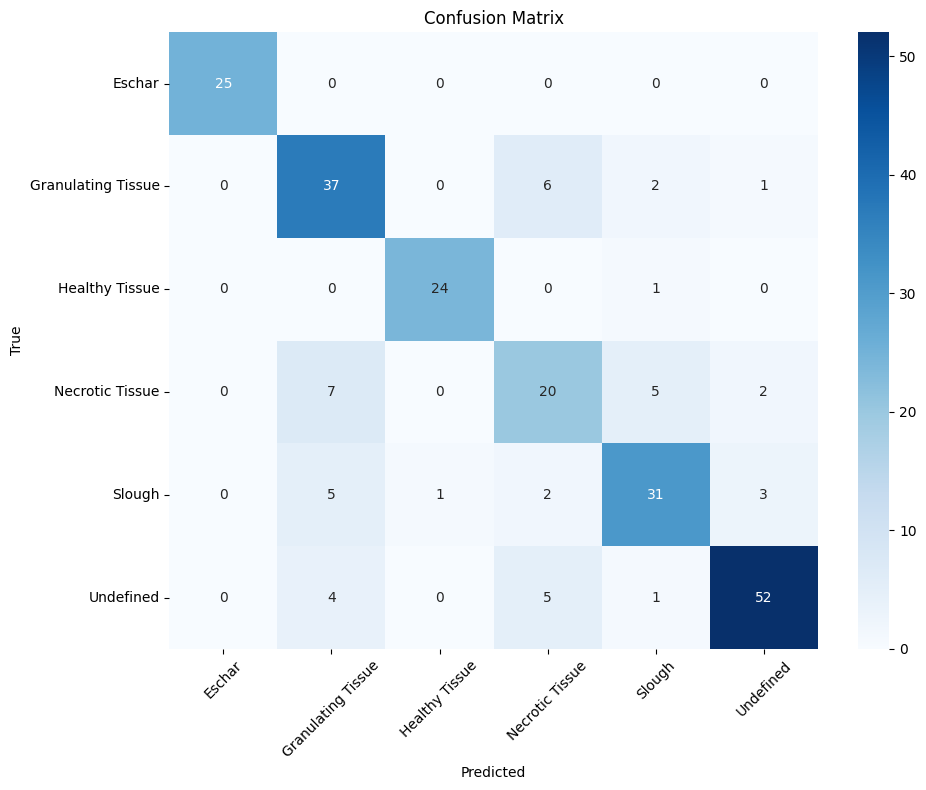

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=list(label_map.values()),
                              zero_division=0))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_map.values()),
                yticklabels=list(label_map.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Evaluate the model
print("\nEvaluating model on test set:")
evaluate_model(model, test_loader)

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_mapping': label_map,
}, 'improved_wound_classifier.pth')



Sample predictions for each class:


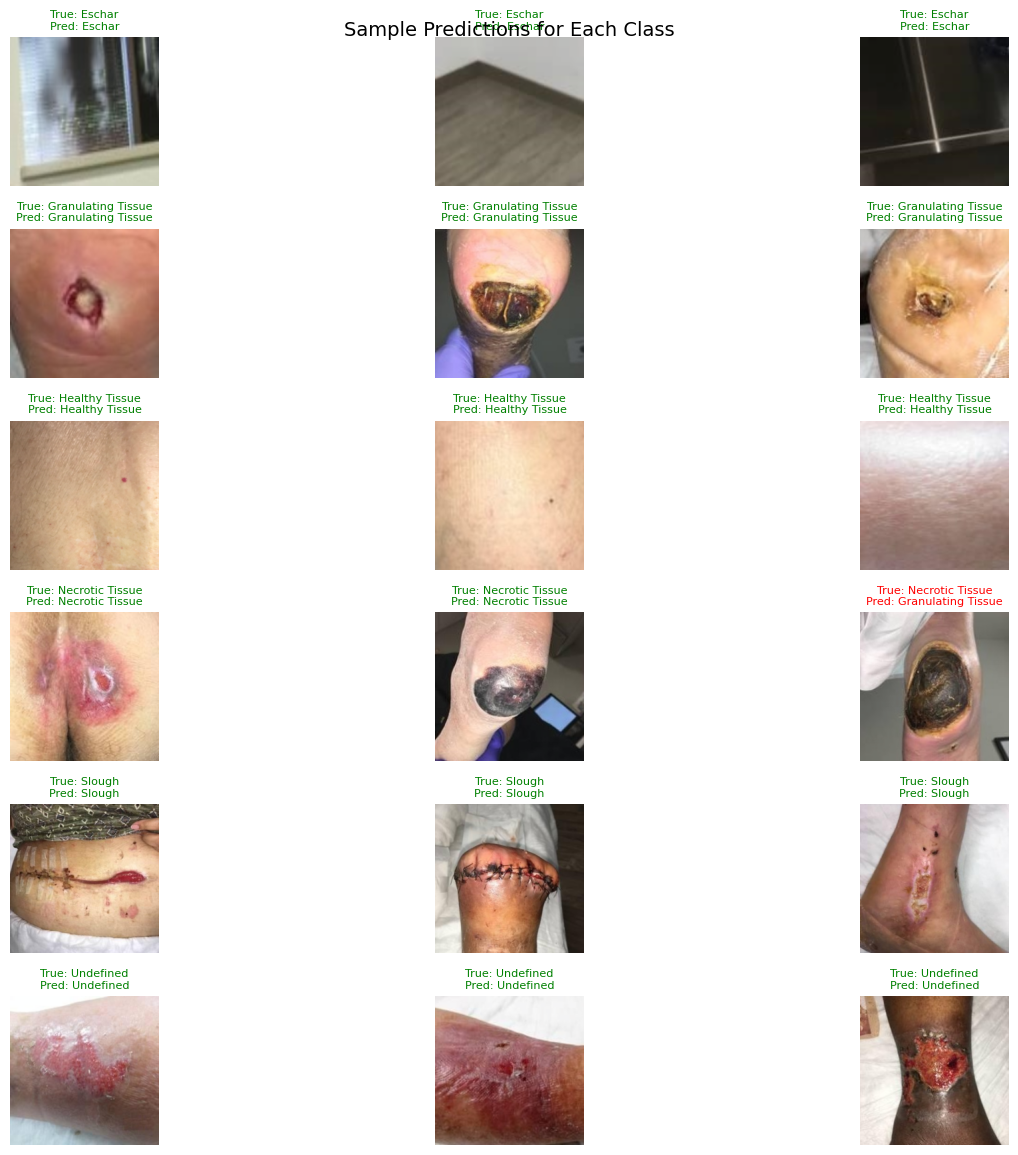

In [14]:


def visualize_predictions_all_labels(model, test_loader, samples_per_class=3):
    model.eval()
    # Dictionary to store examples for each class
    class_examples = {label: {'images': [], 'labels': [], 'preds': []} for label in range(6)}
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            batch_images = inputs.cpu()
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Store examples for each class
            for img, label, pred in zip(batch_images, targets, predicted.cpu()):
                label_idx = label.item()
                if len(class_examples[label_idx]['images']) < samples_per_class:
                    class_examples[label_idx]['images'].append(img)
                    class_examples[label_idx]['labels'].append(label_idx)
                    class_examples[label_idx]['preds'].append(pred.item())
            
            # Check if we have enough examples for all classes
            if all(len(examples['images']) >= samples_per_class for examples in class_examples.values()):
                break
    
    # Plotting
    num_classes = 6
    plt.figure(figsize=(15, 12))  # Increased height to accommodate all classes
    
    for class_idx in range(num_classes):
        images = class_examples[class_idx]['images']
        labels = class_examples[class_idx]['labels']
        preds = class_examples[class_idx]['preds']
        
        for i in range(len(images)):
            plt.subplot(num_classes, samples_per_class, class_idx * samples_per_class + i + 1)
            
            # Denormalize image
            img = images[i].numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            
            # Color-code the title based on prediction correctness
            correct = labels[i] == preds[i]
            color = 'green' if correct else 'red'
            
            plt.title(f'True: {label_map[labels[i]]}\nPred: {label_map[preds[i]]}', 
                     color=color, fontsize=8)
            plt.axis('off')
    
    plt.suptitle('Sample Predictions for Each Class', fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()

# Visualize predictions for all classes
print("\nSample predictions for each class:")
visualize_predictions_all_labels(model, test_loader, samples_per_class=3)

In [15]:
class WoundClassifierInference:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load model and weights
        checkpoint = torch.load(model_path)
        self.model = ImprovedWoundClassifier().to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        self.label_map = checkpoint['class_mapping']
        
        # Define transform for inference
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def predict(self, image):
        # Ensure image is in PIL format
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        
        # Preprocess image
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        # Make prediction
        with torch.no_grad():
            outputs = self.model(image)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        return {
            'class_name': self.label_map[predicted_class],
            'class_id': predicted_class,
            'confidence': confidence
        }

# Example usage:
'''
classifier = WoundClassifierInference('improved_wound_classifier.pth')

# For a single image:
image = Image.open('path_to_image.jpg')
result = classifier.predict(image)
print(f"Predicted class: {result['class_name']}")
print(f"Confidence: {result['confidence']:.2f}")
'''


'\nclassifier = WoundClassifierInference(\'improved_wound_classifier.pth\')\n\n# For a single image:\nimage = Image.open(\'path_to_image.jpg\')\nresult = classifier.predict(image)\nprint(f"Predicted class: {result[\'class_name\']}")\nprint(f"Confidence: {result[\'confidence\']:.2f}")\n'




 A mockup for potential deployment:

- **Mobile App Interface** – React Native-based UI for wound image upload and predictions.
- **Web Interface** – A Streamlit dashboard for predictions.
- **API UI (Swagger/Postman)** – REST API endpoints for image classification.

![Mockup Screenshot]

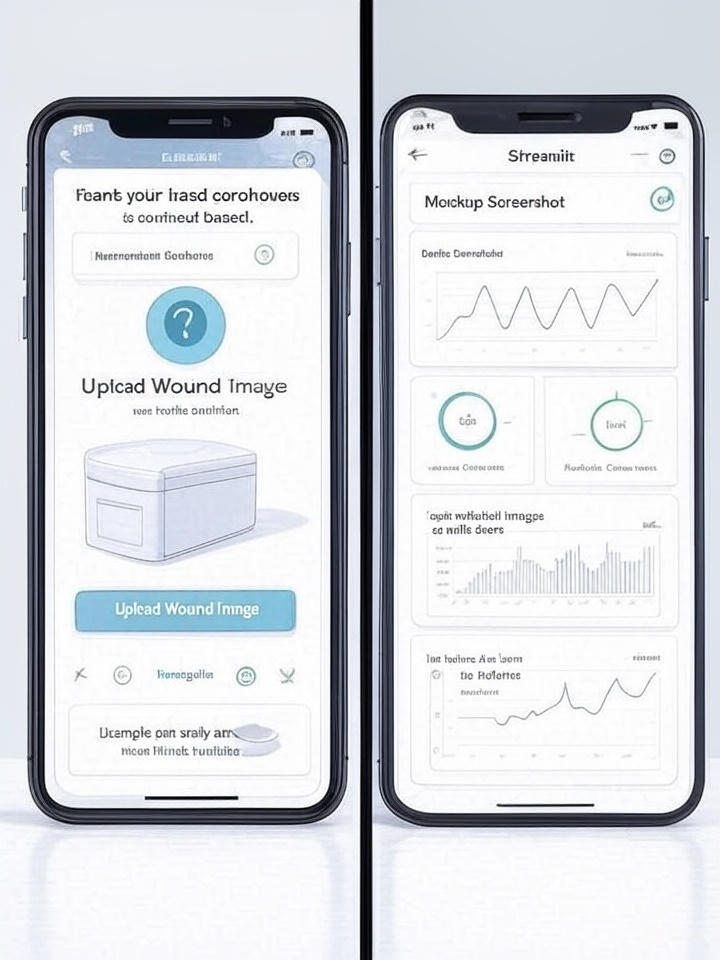


*Example Swagger API request:*

```
POST /predict
Content-Type: multipart/form-data
Body: { "image": <wound_image.jpg> }
```
